# Predicting housing prices

I perform exploratory data analysis, feature engineering and build vareity of machine learning models to predict housing prices using __[this](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)__ kaggle dataset.

**Achyut Kafle**

In [1]:
# Import relevant packages

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from scipy import stats

from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data 
train=pd.read_csv('~/Desktop/Kaggle/data/housing_prices/train.csv')
test=pd.read_csv('~/Desktop/Kaggle/data/housing_prices/test.csv')

In [3]:
# Shape of train and test data
print('Train data shape: ', train.shape)
print('Test data shape: ', test.shape)

Train data shape:  (1460, 81)
Test data shape:  (1459, 80)


In [4]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Exploratory Data Analysis**

**1. Univariate analysis: Sale price**

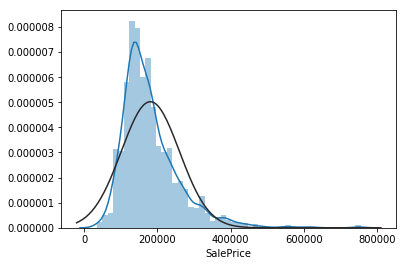

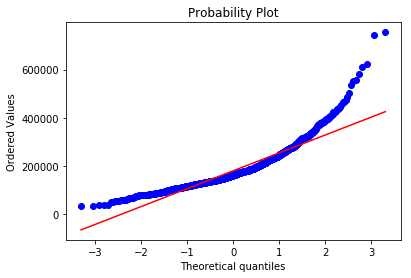

In [5]:
# Distribution of sale price
sns.distplot(train['SalePrice'], fit=norm)
plt.show()

# Probability plot
stats.probplot(train['SalePrice'], plot=plt)
plt.show()

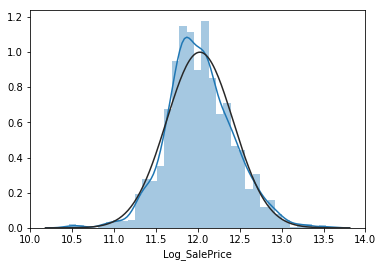

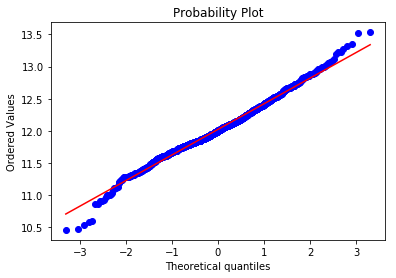

In [6]:
# Log-tranformation of sale price
train['Log_SalePrice']=np.log(train['SalePrice'])

# Distribution of log of sale price
sns.distplot(train['Log_SalePrice'], fit=norm)
plt.show()

# Probability plot
stats.probplot(train['Log_SalePrice'], plot=plt)
plt.show()

**Notes:**
* Sale prices are positively skewed. Log-tranformed sale prices follow normal distribution as shown above.

**2. Bivariate analysis: Sale price and selected continuous variables**

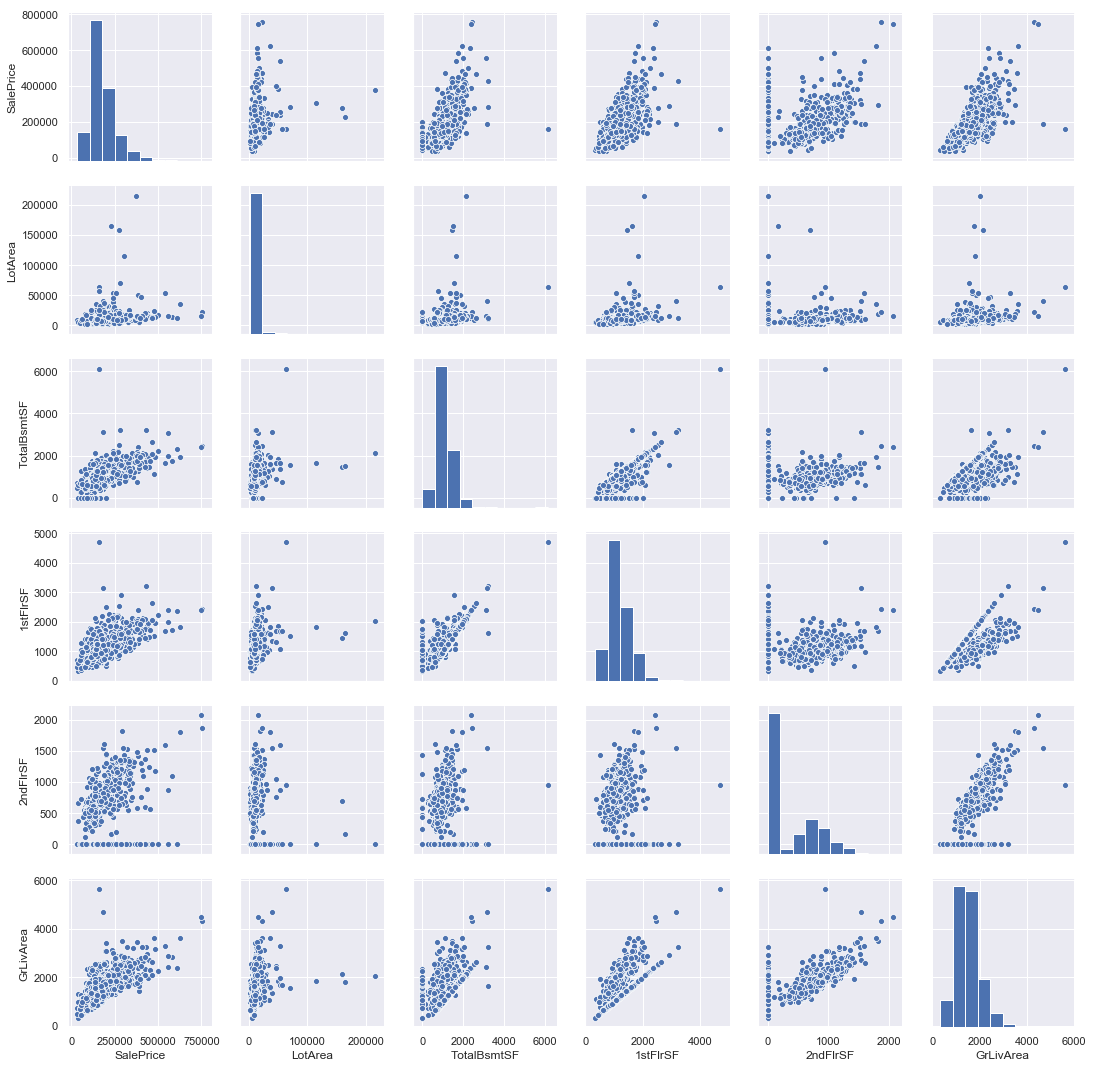

In [7]:
# Scatter plot between sale price and continuous variables
sns.set()
cont_cols = ['SalePrice', 'LotArea','TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea']
sns.pairplot(train[cont_cols], size = 2.5)
plt.show()

**3. Bivariate analysis: Sale price and selected categorical variables**

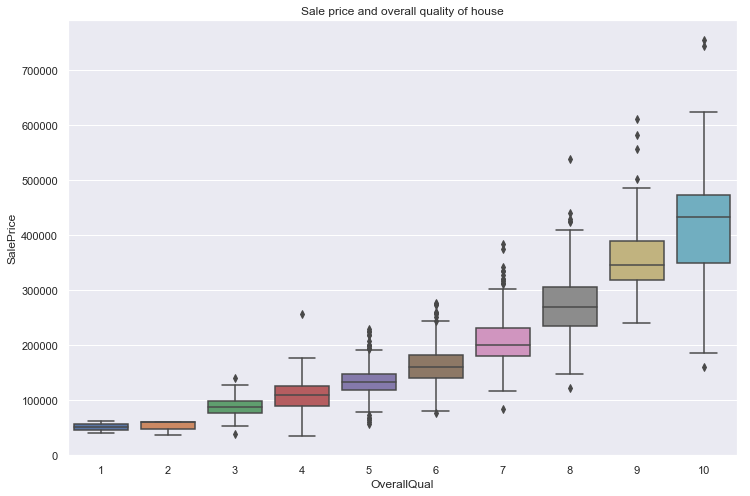

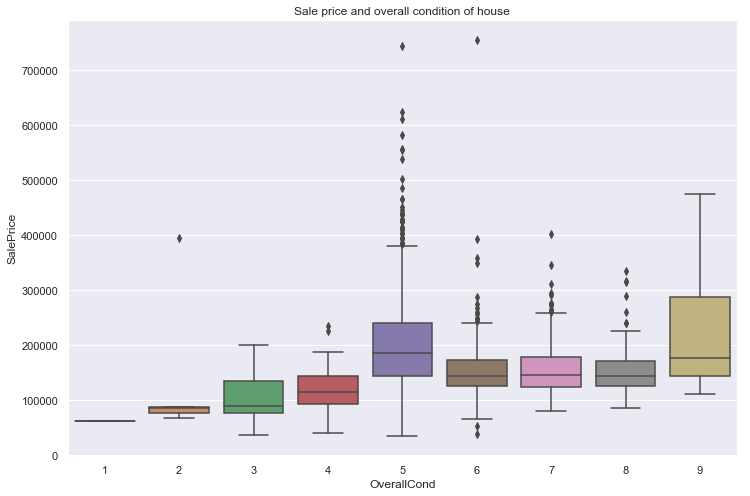

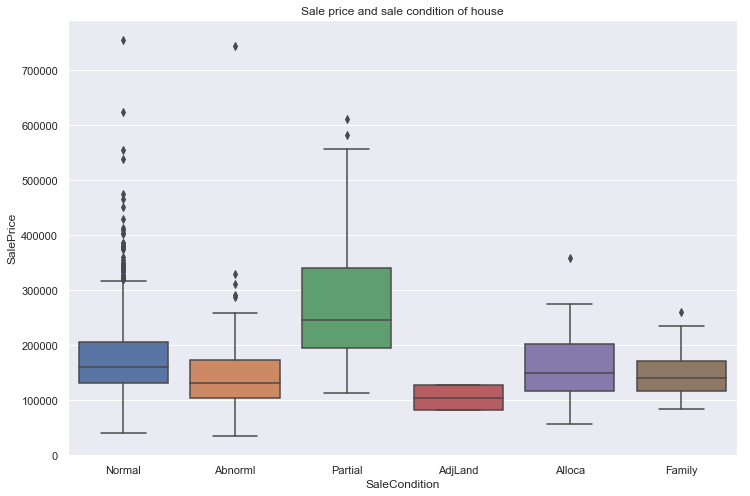

In [8]:
# Sale price and overall quality
plt.subplots(figsize=(12, 8))
sns.boxplot(x="OverallQual", y="SalePrice", data=train)
plt.title('Sale price and overall quality of house')
plt.show()

# Sale price and overall condition
plt.subplots(figsize=(12, 8))
sns.boxplot(x="OverallCond", y="SalePrice", data=train)
plt.title('Sale price and overall condition of house')
plt.show()

# Sale price and sale condition
plt.subplots(figsize=(12, 8))
sns.boxplot(x="SaleCondition", y="SalePrice", data=train)
plt.title('Sale price and sale condition of house')
plt.show()

In [9]:
# Concatenate train and test data before filling in missing values and doing feature engineering
n_train = train.shape[0]
n_test = test.shape[0]
SalePrice_train = train.SalePrice.values
Log_SalePrice_train=train.Log_SalePrice.values
x_all = pd.concat((train, test)).reset_index(drop=True)
x_all.drop(['SalePrice', 'Log_SalePrice'], axis=1, inplace=True)
print("Shape of all X : {}".format(x_all.shape))

Shape of all X : (2919, 80)


**Missing values**

In [10]:
# Inspect columns that have missing values
nan_data = x_all.isnull().apply(sum).sort_values(ascending = False)
nan_cols = nan_data[nan_data > 0]
print(nan_cols)
print("\nThere are {} variables with missing(nan) values".format(len(nan_cols)))

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageFinish     159
GarageYrBlt      159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
Exterior2nd        1
KitchenQual        1
Exterior1st        1
GarageCars         1
TotalBsmtSF        1
GarageArea         1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
SaleType           1
dtype: int64

There are 34 variables with missing(nan) values


**Filling in missing values**

In [11]:
# Fill 'None' for missing values in columns where nan actually means 'None'
none_cols=['PoolQC', 'MiscFeature', 'Alley', 'Fence','FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
           'GarageType','BsmtCond','BsmtExposure','BsmtQual','BsmtFinType1','BsmtFinType2','MasVnrType','MSSubClass']
for col in none_cols:
    x_all[col] = x_all[col].fillna("None")

In [12]:
# Fill 0 for missing values in columns where missing values may mean absence
zero_cols=['GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
           'BsmtFullBath', 'BsmtHalfBath','MasVnrArea']
for col in zero_cols:
    x_all[col] = x_all[col].fillna(0)

In [13]:
# Fill most common value i.e., model for the following continuous variables
mode_cols=['SaleType','Exterior1st','Exterior2nd','KitchenQual','Electrical','MSZoning', 'Functional', 'Utilities']
for col in mode_cols:
    x_all[col] = x_all[col].fillna(x_all[col].mode()[0])

In [14]:
# Fill LotFrontage by neighborhood
x_all["LotFrontage"] = x_all.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [15]:
# Inspect if there are any missing values
nan_data = x_all.isnull().apply(sum).sort_values(ascending = False)
nan_cols = nan_data[nan_data > 0]
print(nan_cols)
print("\nThere are {} variables with missing(nan) values".format(len(nan_cols)))

Series([], dtype: int64)

There are 0 variables with missing(nan) values


**Feature engineering**

In [16]:
# Total square footage of house
x_all['TotalSqFt']=x_all['TotalBsmtSF'] + x_all['1stFlrSF'] + x_all['2ndFlrSF']

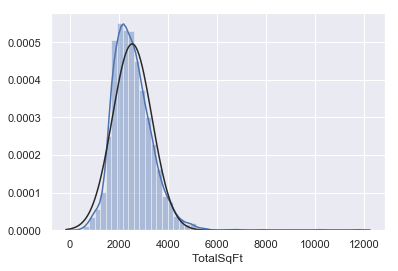

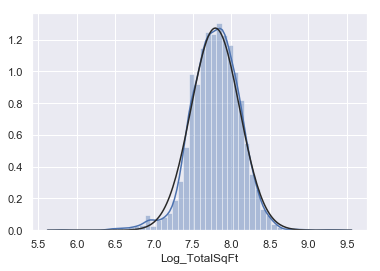

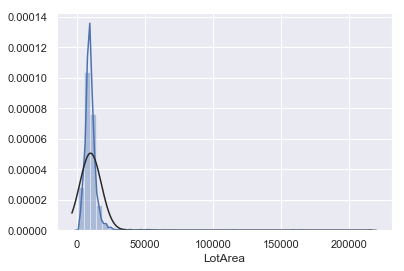

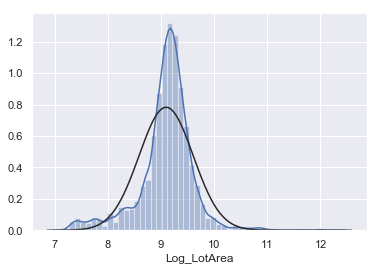

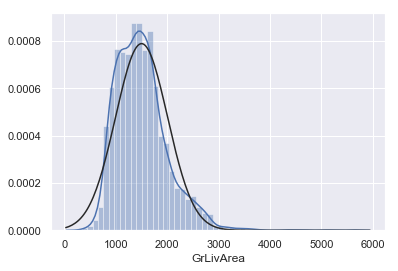

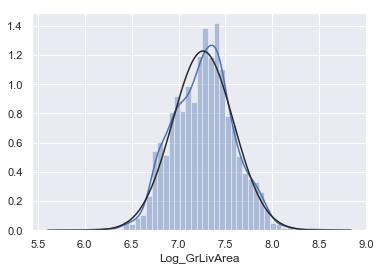

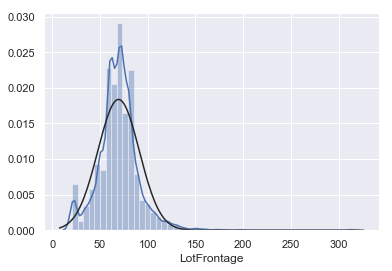

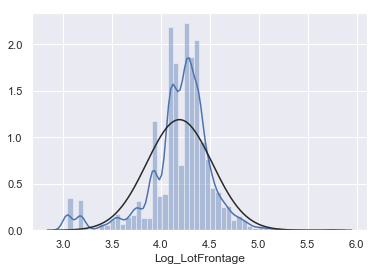

In [17]:
# Log-transformation of selected continuous variables
log_cols=['TotalSqFt', 'LotArea', 'GrLivArea','LotFrontage']
for col in log_cols:
    sns.distplot(x_all[col], fit=norm)
    plt.show()
    
    x_all['Log_'+ col]=np.log(x_all[col])
    sns.distplot(x_all['Log_'+col], fit=norm)
    plt.show()  

In [18]:
# Convert columns that use numbers to represent categorical values to categorical variables
convert_cat_cols=['MSSubClass','OverallQual','OverallCond','MoSold','YrSold']

for col in convert_cat_cols:
    x_all[col]=x_all[col].astype(str)

In [19]:
# Convert categorical variablces into dummy features
x_all = pd.get_dummies(x_all)

In [20]:
x_all_train = x_all[:n_train]
x_all_test = x_all[n_train:]

In [21]:
# Define a function to calculate mse score using 5-fold cross-validation
def cv_rmse(model):
    cv=KFold(n_splits=5, shuffle=True, random_state=321).get_n_splits(x_all_train.values)
    rmse= np.sqrt(-cross_val_score(model, x_all_train.values, Log_SalePrice_train, scoring="neg_mean_squared_error", 
                                   cv = cv))
    return(rmse)

**Regularized linear models**

**1. Ridge regression**

In [22]:
# Define a ridge reg
ridge_reg=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, 
                solver='auto', tol=0.001)

# Ridge cv_rmse score
cv_rmse(ridge_reg).mean()

0.13480223748466114

In [23]:
# Tune alpha
alphas = [0.05, 0.1, 1, 3, 5, 10, 15, 30, 50]
cv_ridge = [cv_rmse(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

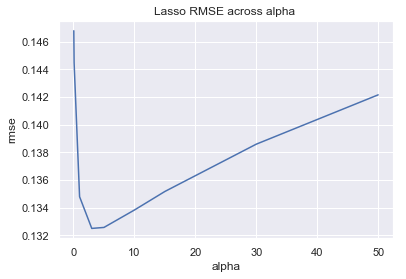

In [24]:
# Plot
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Lasso RMSE across alpha ")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

**2. LASSO**

In [25]:
# Define a ridge reg
lasso_reg=Lasso()

# Ridge cv_rmse score
cv_rmse(lasso_reg).mean()

0.19668271575054988

In [26]:
# Tune alpha
alphas = [0.05, 0.1, 1, 3, 5, 10, 15, 30, 50]
cv_lasso = [cv_rmse(Lasso(alpha = alpha)).mean() 
            for alpha in alphas]

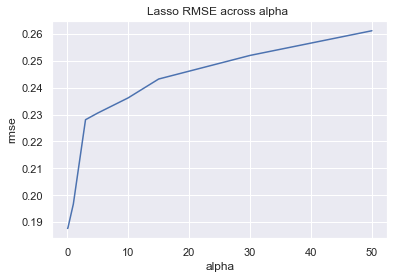

In [27]:
# Plot
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Lasso RMSE across alpha ")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()